# Differential Binding Analysis with single-cell ATAC-seq

Here we write the function to do Differential Binding analysis with single-cell ATAC-seq data. As single-cell ATAC-seq is essentially binary signal we are designing algorithm for binary data.

* Data preperation: The user has to prepare a samplesheet as instructed in the DiffBind tutorial.

* Requried dependency
    * samtools
    * macs2

__Important Note:__

 * The functions in the notebook finds the clusters and does Differential Binding Analysis based on merging all the peaks from macs2 callpeak. The other approach is to merge all the BAM files and then call peaks on the merged BAM file. However, this approach is a bit time-consuming. I apply both those approaches here.
 * __How do I select TOP peaks__: I first concatanate all the peaks of all the cells in a single file. Then I call `bedtools merge` command to merge the overlapping peaks. During this call, I take the median q-value of the peaks that are merged together. For the non-overlapping peaks, q-value that is given by `macs2` are kept. But this might create problem. As the q-values are independent for each of the cells, they might not represent the same weight in the merged peak file.

In [1]:
import subprocess, os, csv, signal, pysam, rpy2
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
%load_ext rpy2.ipython

In [234]:
%%R
library(rtracklayer)
library(prabclus)
library(rGREAT)
library(ggplot2)
library(ComplexHeatmap)
library(Rtsne)

In [237]:
%%R
library(scde)
library(DESeq2)
library(ggplot2)
library(made4)
library(irlba)
library(scater)
library(scran)
library(ComplexHeatmap)
library(genefilter)
library(ccRemover)
library(Rtsne)
library(plotly)
library(MASS)
library(M3Drop)

Defining the user-defined functions for Differential Binding Analysis

In [266]:
%%R
peakAccesibility <- function(mergedPeakFile, peakFolder, peakFilePattern, outputFolder, outputPeakFileName){
    if(length(list.files(path=peakFolder, pattern = paste0(peakFilePattern,'.bed'), full.names=TRUE))>0){
        files = list.files(path=peakFolder, pattern = paste0(peakFilePattern,'.bed'), full.names=TRUE)
        unlink(files)
    }
    formatingToBed(mergedPeakFile, peakFolder, peakFilePattern, outputFolder)
    peakFilePattern = paste0(peakFilePattern,'.bed')
    query = import(mergedPeakFile)
    queryDF <- data.frame(query)
    #queryDF <- queryDF[order(queryDF$name, decreasing=TRUE),]    
    
    totalOverlap <- data.frame(seqnames = queryDF$seqnames, start = queryDF$start, end = queryDF$end)    
    files <- list.files(path=peakFolder, pattern = peakFilePattern, full.names=TRUE)
    cellName <- list.files(path=peakFolder, pattern = peakFilePattern)
    for (i in 1:length(files)){
        subject = import(files[i])
        hits = findOverlaps(query, subject)
        hitsDF <- data.frame(hits)
        cellName[i] <- gsub(peakFilePattern, '', cellName[i])
        totalOverlap[hitsDF$queryHits, cellName[i]] <- 1
        totalOverlap[-hitsDF$queryHits, cellName[i]] <- 0
    }
    outputFile = paste0(outputFolder,outputPeakFileName)
    write.csv(totalOverlap, outputFile, row.names=FALSE)    
}    

In [6]:
%%R
formatingToBed <- function(mergedPeakFile, peakFolder, peakFilePattern, outputFolder){
    files <- list.files(path=peakFolder, pattern = peakFilePattern, full.names=TRUE)
    for (i in 1:length(files)){
        narrowPeak <- read.csv(files[i], header=FALSE, sep='\t')
        write.table(narrowPeak[,1:4], paste0(files[i],'.bed'), 
                    row.names=FALSE, sep='\t', col.names=FALSE, quote=FALSE)
    }
}

In [7]:
%%R
getJaccardDist <- function(cdBinary){
        
    if(colnames(cdBinary[,2:3])[1] == 'start' && colnames(cdBinary[,2:3])[2] == 'end'){
        SingleCell.Binary <- cdBinary[,4:(dim(cdBinary)[2])]
    }
    else
        SingleCell.Binary <- cdBinary
    
    
    SingleCell.Binary.Jaccard <- jaccard(as.matrix(SingleCell.Binary))
    
    return(SingleCell.Binary.Jaccard)
}

In [8]:
%%R
plotCluster <- function(cdBinary, k, groups=NULL, cell.names, ret.val=FALSE, text.label=FALSE){

    if(missing(k)){
        stop("ERROR: Number of groups \"k\" is missing")
    }
    if(missing(ret.val)){
        ret.val = FALSE
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=k)
 
    if(is.null(groups)){
        df<-data.frame(x=fit$points[,1],y=fit$points[,2], Cell=colnames(SingleCell.Binary.Jaccard))
        p <- ggplot(df, aes_string(x="x",y ="y"))
    }
    else{
        df<-data.frame(x=fit$points[,1],y=fit$points[,2], Cell=colnames(SingleCell.Binary.Jaccard), groups=groups)
        p <- ggplot(df, aes_string(x="x",y ="y", color="groups"))
    }
    
    p <- p + ggtitle("MDS with Jaccard Distance Matrix") + theme(plot.title = element_text(size = 16, face = "bold"))
    p <- p + geom_point(size = 3)
    p <- p + xlab("Corrdinate 1") 
    p <- p + ylab("Corrdinate 2")
    #p <- p + theme(axis.title = element_text(size = 14), axis.text = element_text(size = 14),
    #legend.text = element_text(size = 14), legend.title = element_text(size = 14))
    if(text.label==TRUE){
        p<-p + geom_text(data=df,aes(label=colnames(SingleCell.Binary.Jaccard)),
                         alpha=0.6,size=3, vjust=1,hjust=0.7,angle=45)
    }        
    
    print(p)
    
    if(ret.val == TRUE)
        return(fit)
}

In [252]:
%%R
plotPCAJaccard <- function(cdBinary, k, groups=NULL, cell.names, ret.val=FALSE , text.label=FALSE, title=""){
    
    if(missing(k)){
        stop("ERROR: Number of groups \"k\" is missing")
    }
    if(missing(ret.val)){
        ret.val = FALSE
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    FinalPCAData <- t(SingleCell.Binary.Jaccard)
    PCx=1
    PCy=2
    pcaPRComp <- prcomp(FinalPCAData)
    percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
 
    if(is.null(groups)){
        df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy])
        p1<-ggplot(df, aes_string(x="PCX",y ="PCY"))        
    }
    else{
        df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy], groups=groups)
        p1<-ggplot(df, aes_string(x="PCX",y ="PCY", color="groups"))             
    }          
    if(title=="")
        p1<-p1+ggtitle("PCA with Jacard Matrix")
    else
        p1<-p1+ggtitle(title)
    p1<-p1+geom_point(size = 3)
    p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
    p1<-p1+ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
    if(text.label == TRUE){
        p1<-p1+geom_text(data=df,aes(label=colnames(SingleCell.Binary.Jaccard)),
                       alpha=0.6,size=3, vjust=1,hjust=0.7,angle=45, color="black")
    }
    
    p1<-p1+scale_fill_hue(l=40)
    return(p1)
}

In [56]:
%%R
plotHeatmapJaccard <- function(cdBinary, ret.val=FALSE){
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)         
    p <- Heatmap(SingleCell.Binary.Jaccard,row_names_gp = gpar(fontsize = 8),
                 column_names_gp = gpar(fontsize = 8), name='Jacard')
    print(p)
    if(ret.val == TRUE)
        return(hclust(as.dist(SingleCell.Binary.Jaccard)))
}

In [11]:
%%R
getGreatAnalysis <- function(Input, species, p_threshold){
    
    job = submitGreatJob(bed, version = "3.0", species=species)   
    tb = getEnrichmentTables(job)
    
    write.table(tb[[1]][tb[[1]]$Binom_Raw_PValue< p_threshold,],'Great_GO_Molecular_Functions')
    write.table(tb[[2]][tb[[2]]$Binom_Raw_PValue< p_threshold,],'Great_GO_Biological_Process')
    write.table(tb[[3]][tb[[3]]$Binom_Raw_PValue< p_threshold,],'Great_GO_Cellular_Component')
    
    print(job)
    
    res = plotRegionGeneAssociationGraphs(job)    
}

In [12]:
%%R
getDiffBind <- function(cdBinary, groups=NULL){

    if (length(levels(groups)) != 2) {
        stop(paste("ERROR: wrong number of levels in the grouping factor (", 
            paste(levels(groups), collapse = " "), "), but must be two.", 
            sep = ""))
    }
    if (is.null(groups)){
        stop("ERROR: groups factor is not provided")
    }
    
    
    SingleCell.Group1.CellNames <- names(groups[groups==levels(groups)[1]])
    SingleCell.Group2.CellNames <- names(groups[groups==levels(groups)[2]])
    
    SingleCell.Group1.Binary <- cdBinary[,SingleCell.Group1.CellNames]
    SingleCell.Group2.Binary <- cdBinary[,SingleCell.Group2.CellNames]

    SingleCell.Group1.ZeroCount <- rowSums(SingleCell.Group1.Binary==0)
    SingleCell.Group2.ZeroCount <- rowSums(SingleCell.Group2.Binary==0)
    SingleCell.Group1.OneCount <- rowSums(SingleCell.Group1.Binary==1)
    SingleCell.Group2.OneCount <- rowSums(SingleCell.Group2.Binary==1)
    
    SingleCell.Group1VsGroup2 <- data.frame(Chr = cdBinary[,1],
                                           Start = cdBinary[,2],
                                           end = cdBinary[,3])

    SingleCell.Group1VsGroup2$group1OneCounts <- SingleCell.Group1.OneCount
    SingleCell.Group1VsGroup2$group2OneCounts <- SingleCell.Group2.OneCount
    SingleCell.Group1VsGroup2$log2Fold <- log2(SingleCell.Group1.OneCount+1) - log2(SingleCell.Group2.OneCount+1)
    pvalue = vector(mode="numeric", length=length(SingleCell.Group2.OneCount))
    nGenes <- nrow(SingleCell.Group1.Binary)
    
    
    for(i in 1:length(SingleCell.Group2.OneCount))
    {
        contingencyTable <- matrix(c(SingleCell.Group1.ZeroCount[i], SingleCell.Group2.ZeroCount[i],
                                     SingleCell.Group1.OneCount[i], SingleCell.Group2.OneCount[i]), ncol=2)
        SingleCell.Group1VsGroup2$pvalue[i] <- fisher.test(contingencyTable)$p.value        
    }
    
    # Bonferroni correction
    SingleCell.Group1VsGroup2$p_adjust <- p.adjust(SingleCell.Group1VsGroup2$pvalue, method="bonferroni")

    write.csv(SingleCell.Group1VsGroup2[order(SingleCell.Group1VsGroup2$pvalue, decreasing=FALSE),], 
              paste0(levels(groups)[1],'_vs_',levels(groups)[2],'.csv'), row.names=FALSE)
    
    return(SingleCell.Group1VsGroup2)    
}

## Python Function

### Merging Peak Files

In [199]:
def mergePeaks(peakFolder, macs2FilePattern):
    mergedPeakFile = peakFolder+'mergedPeaks.bed'
    tmpPeakFile = peakFolder + 'tmpPeak.txt'
    concatCmd='cat '
    tmpPeakSortFile = peakFolder + 'tmpPeakSort.txt'
    for root, folder, files in os.walk(peakFolder):
        files = [os.path.join(root, f) for f in files if (f.endswith(macs2FilePattern))]
        for f in files:
            concatCmd = concatCmd + f + ' '

    concatCmd = concatCmd + ' > ' + mergedPeakFile
    subprocess.call(concatCmd, shell=True)
    sortCmd = 'sort -k1,1 -k2,2n ' + mergedPeakFile + ' > ' + tmpPeakFile  
    subprocess.call(sortCmd, shell=True)
    if(macs2FilePattern == '_peaks.narrowPeak' or macs2FilePattern == 'peaks.narrowPeak'):
        bedToolsCmd ='bedtools merge -i ' + tmpPeakFile + ' -c 9 -o median > ' + mergedPeakFile
        subprocess.call(bedToolsCmd, shell=True)
    elif(macs2FilePattern == '_summits_shifted.bed'):
        bedToolsCmd ='bedtools merge -i ' + tmpPeakFile + ' -c 5 -o median > ' + mergedPeakFile
        subprocess.call(bedToolsCmd, shell=True)
    else:
        print('Invalid pattern... Allowed only _summits_shifted.bed or _peaks.narrowPeak... Exiting!!')
        return
    sortMergeCmd = 'sort -nrk4 ' +  mergedPeakFile + ' > ' + tmpPeakSortFile
    subprocess.call(sortMergeCmd, shell=True)
    #copyTopCmd = 'head -n ' + str(topX) + ' ' + tmpPeakSortFile + ' > ' + mergedPeakFile
    copyTopCmd =  'cat ' + tmpPeakSortFile + ' > ' + mergedPeakFile
    subprocess.call(copyTopCmd, shell=True)
    rmvCmd = 'rm ' + tmpPeakFile
    subprocess.call(rmvCmd, shell=True)
    rmvCmd = 'rm ' + tmpPeakSortFile
    subprocess.call(rmvCmd, shell=True)     
    

### Merging BAM Files

In [152]:
def getMergedBam(BAMFolder, BAMFilePattern):
    
    import pandas as pd
    
    mergeFiles = ''
    for root, folder, files in os.walk(BAMFolder):
            files = [os.path.join(root, f) for f in files if (f.endswith(BAMFilePattern))]
            for f in files:
                mergeFiles = mergeFiles +  f + ' '
    
        
    mergeCommand = 'samtools merge ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup.bam' + ' ' + mergeFiles    
    subprocess.call(mergeCommand, shell=True)   
    
    sortMergeCmd = 'samtools sort ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup.bam' \
                    + ' ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_sorted'        
    subprocess.call(sortMergeCmd, shell=True)
    
    indexMergeCmd = 'samtools index ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_sorted.bam'
    subprocess.call(indexMergeCmd, shell=True)
    

In [157]:
def getAggregatedPeak(BAMFolder, BAMFilePattern):
    getMergedBam(BAMFolder, BAMFilePattern)
    
    MergedMacs2Cmd = 'macs2 callpeak -t ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_sorted.bam' +' -n ' \
                    + BAMFolder + 'AllFiles_Filtered' +' -q 0.01 -g hs -f BAM --nomodel --nolambda --shift -75 \
                    --extsize 150 -B --SPMR --call-summits --keep-dup all'
    subprocess.call(MergedMacs2Cmd, shell=True)

## Generating Binary for OE19 cells

### With All Peaks

### Configuration File

In [114]:
# This cell holds the parameters for the tools

# Set this parameter to the folder where all the Peak Files are
peakFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredMacs2Files/'

# Set this parameter to the pattern that is common to all the peak file names that you wish to merge. 
# for eg, if you want to combine OE19_C01_peaks.narrowPeak and OE19_C02_peaks.narrowPeak then the
# pattern would be '_peaks.narrowPeak'
# Allowed patterns while calling with the pipeline provided here are
# _summits_shifted.bed and '_peaks.narrowPeak'
peakFilePattern = '_peaks.narrowPeak'

# This would be automatically set to 'mergedPeaks.bed' file in peakFolder folder
mergedPeakFile = peakFolder + 'mergedPeaks.bed'

# Set this folder to where the PeakHits.csv File would be saved
outputFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredMacs2Files/'

# This will be automatically set to the 'PeakHits.csv' file in outputFolder folder
peakFile = outputFolder + 'PeakHits.csv'

In [115]:
mergePeaks(peakFolder, peakFilePattern)

In [116]:
%%R -i mergedPeakFile,peakFolder,peakFilePattern,outputFolder
peakAccesibility(mergedPeakFile, peakFolder, peakFilePattern, outputFolder)

In [117]:
%%R -w 600 -h 600 -i peakFile
cdFinal <- read.csv(peakFile, header=TRUE)

In [118]:
%%R
#colnames(cdFinal)

sg <- factor(gsub("(D|E).*", "\\1", colnames(cdFinal[,4:dim(cdFinal)[2]])), levels = c("D", "E"))
# the group factor should be named accordingly
names(sg) <- colnames(cdFinal[,4:dim(cdFinal)[2]]) 
table(sg)

sg
 D  E 
84 89 


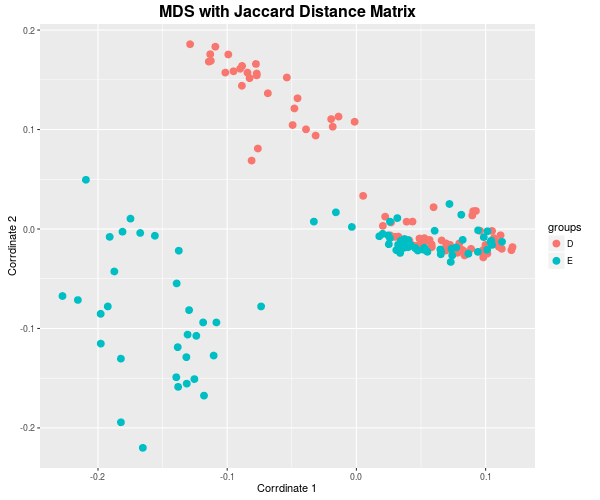

In [119]:
%%R -w 600 -h 500
cluster.cord <- plotCluster(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE)

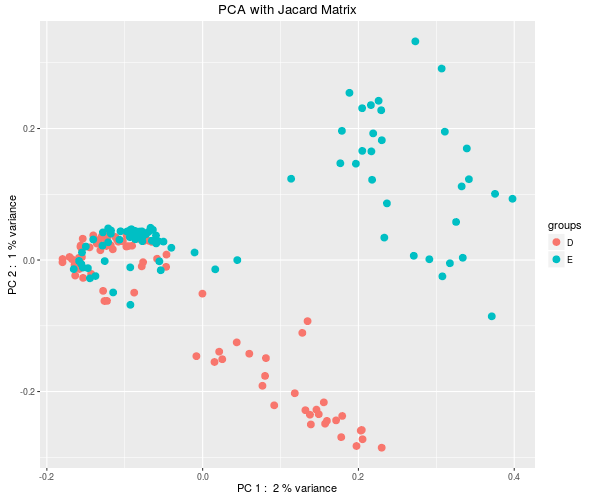

In [120]:
%%R -w 600 -h 500
cluster.cord <- plotPCAJaccard(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE)

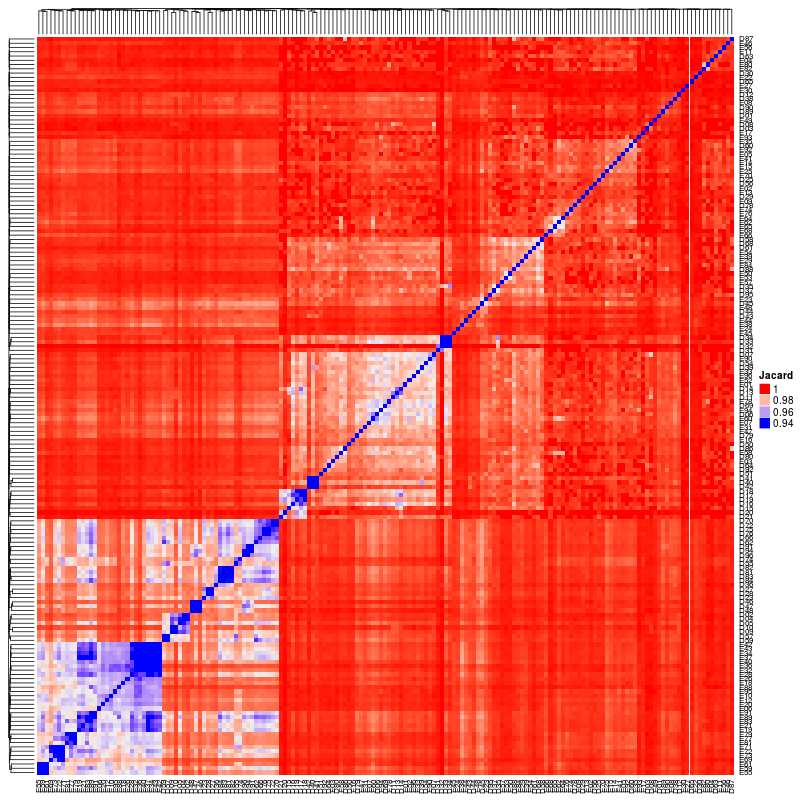

In [121]:
%%R -w 800 -h 800 
hc <- plotHeatmapJaccard(cdFinal, ret.val=TRUE)

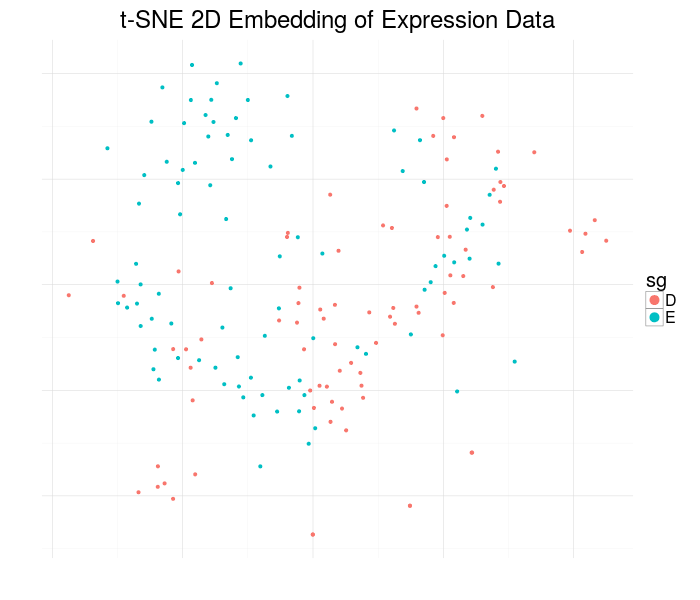

In [122]:
%%R -w 700 -h 600
tsne_out <- Rtsne(t(cdFinal[,4:dim(cdFinal)[2]]),check_duplicates = FALSE, pca = TRUE, 
              perplexity=30, theta=0.0)
p <- ggplot(as.data.frame(tsne_out$Y), aes(x=V1, y=V2, color=sg)) +
     geom_point(size=1.25) +
     guides(colour = guide_legend(override.aes = list(size=4))) +
     xlab("") + ylab("") +
     ggtitle("t-SNE 2D Embedding of Expression Data") +
     theme_light(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
print(p)

### With top 50000 Peaks

In [123]:
# This cell holds the parameters for the tools

# Set this parameter to the folder where all the Peak Files are
peakFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredMacs2Files/'

# Set this parameter to the pattern that is common to all the peak file names that you wish to merge. 
# for eg, if you want to combine OE19_C01_peaks.narrowPeak and OE19_C02_peaks.narrowPeak then the
# pattern would be '_peaks.narrowPeak'
# Allowed patterns while calling with the pipeline provided here are
# _summits_shifted.bed and '_peaks.narrowPeak'
peakFilePattern = '_peaks.narrowPeak'

# This would be automatically set to 'mergedPeaks.bed' file in peakFolder folder
mergedPeakFile = peakFolder + 'mergedPeaks.bed'

# Set this folder to where the PeakHits.csv File would be saved
outputFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredMacs2Files/'

# This will be automatically set to the 'PeakHits.csv' file in outputFolder folder
peakFile = outputFolder + 'PeakHits.csv'

# If we want to choose top X peaks we set the parameter here and then run 'mergePeaksTopSelected' instead of mergePeaks
topX = 50000

In [124]:
mergePeaks(peakFolder, peakFilePattern)

In [125]:
%%R -i mergedPeakFile,peakFolder,peakFilePattern,outputFolder
topX=50000
peakAccesibility(mergedPeakFile, peakFolder, peakFilePattern, outputFolder, topX)

In [126]:
%%R -w 600 -h 600 -i peakFile
cdFinal <- read.csv(peakFile, header=TRUE)

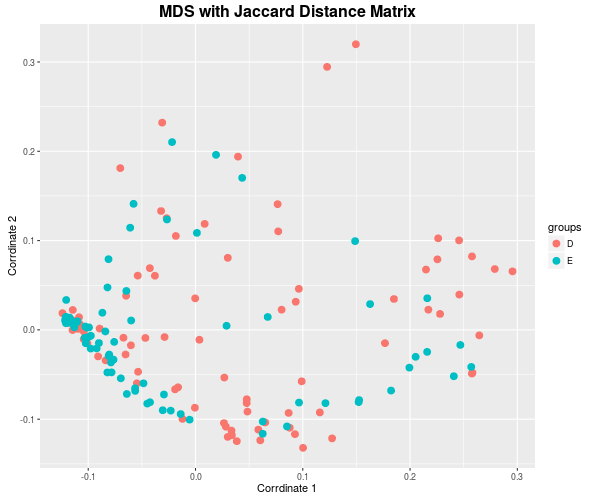

In [127]:
%%R -w 600 -h 500
cluster.cord <- plotCluster(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE)

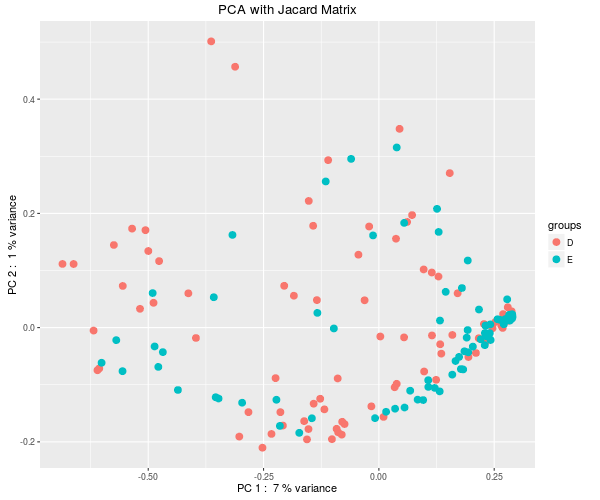

In [128]:
%%R -w 600 -h 500
cluster.cord <- plotPCAJaccard(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE)

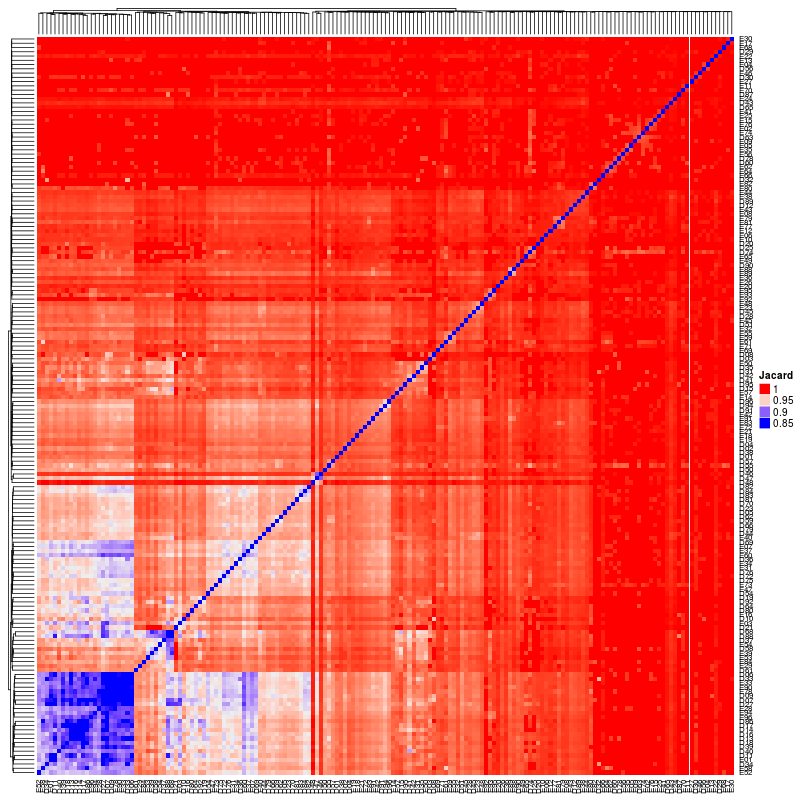

In [129]:
%%R -w 800 -h 800 
hc <- plotHeatmapJaccard(cdFinal, ret.val=TRUE)

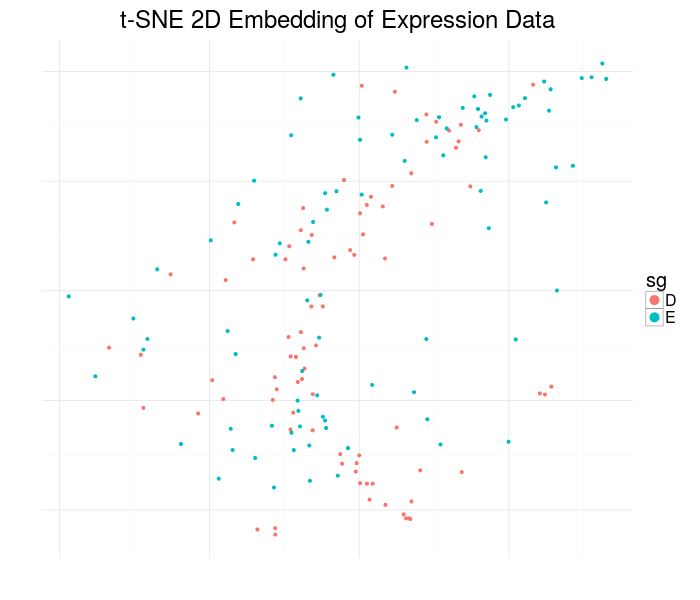

In [130]:
%%R -w 700 -h 600
tsne_out <- Rtsne(t(cdFinal[,4:dim(cdFinal)[2]]),check_duplicates = FALSE, pca = TRUE, 
              perplexity=30, theta=0.0)
p <- ggplot(as.data.frame(tsne_out$Y), aes(x=V1, y=V2, color=sg)) +
     geom_point(size=1.25) +
     guides(colour = guide_legend(override.aes = list(size=4))) +
     xlab("") + ylab("") +
     ggtitle("t-SNE 2D Embedding of Expression Data") +
     theme_light(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
print(p)

### Top 20000

In [131]:
%%R -i mergedPeakFile,peakFolder,peakFilePattern,outputFolder
topX = 20000
peakAccesibility(mergedPeakFile, peakFolder, peakFilePattern, outputFolder, topX)

In [132]:
%%R -w 600 -h 600 -i peakFile
cdFinal <- read.csv(peakFile, header=TRUE)

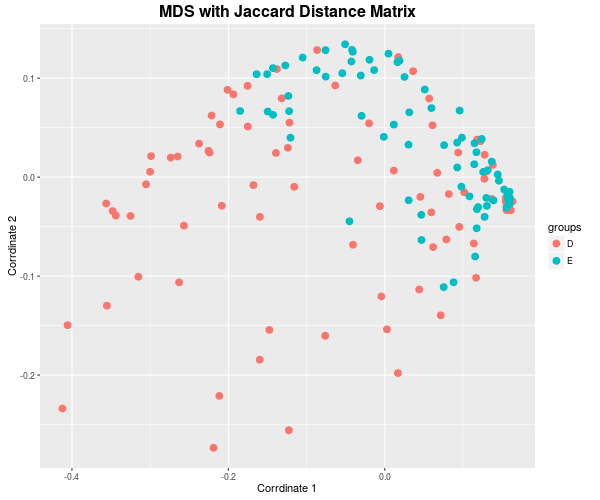

In [133]:
%%R -w 600 -h 500
cluster.cord <- plotCluster(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE)

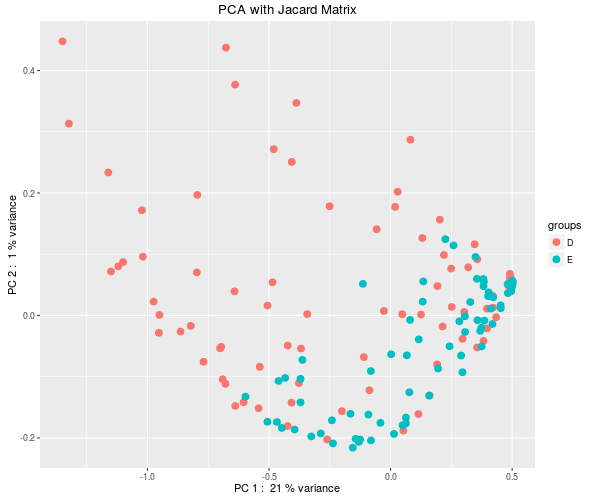

In [134]:
%%R -w 600 -h 500
cluster.cord <- plotPCAJaccard(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE)

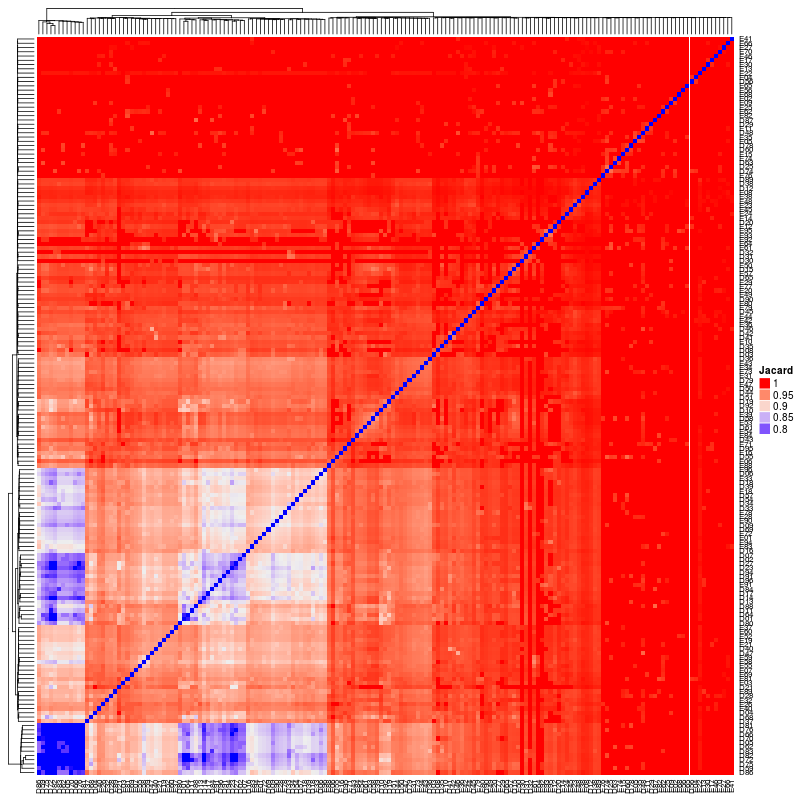

In [135]:
%%R -w 800 -h 800 
hc <- plotHeatmapJaccard(cdFinal, ret.val=TRUE)

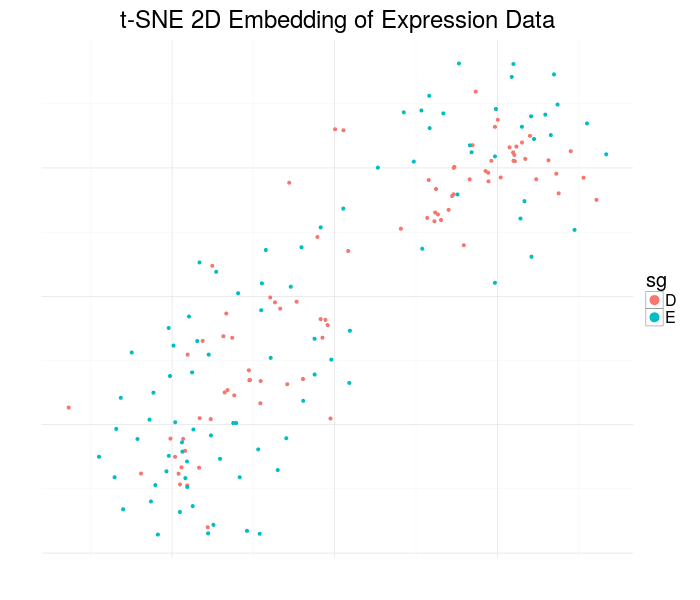

In [113]:
%%R -w 700 -h 600
tsne_out <- Rtsne(t(cdFinal[,4:dim(cdFinal)[2]]),check_duplicates = FALSE, pca = TRUE, 
              perplexity=30, theta=0.0)
p <- ggplot(as.data.frame(tsne_out$Y), aes(x=V1, y=V2, color=sg)) +
     geom_point(size=1.25) +
     guides(colour = guide_legend(override.aes = list(size=4))) +
     xlab("") + ylab("") +
     ggtitle("t-SNE 2D Embedding of Expression Data") +
     theme_light(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
print(p)

## Peaks where trimmomatic was used

In [136]:
# This cell holds the parameters for the tools

# Set this parameter to the folder where all the Peak Files are
peakFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredMacs2FilesTrimmo/'

# Set this parameter to the pattern that is common to all the peak file names that you wish to merge. 
# for eg, if you want to combine OE19_C01_peaks.narrowPeak and OE19_C02_peaks.narrowPeak then the
# pattern would be '_peaks.narrowPeak'
# Allowed patterns while calling with the pipeline provided here are
# _summits_shifted.bed and '_peaks.narrowPeak'
peakFilePattern = '_peaks.narrowPeak'

# This would be automatically set to 'mergedPeaks.bed' file in peakFolder folder
mergedPeakFile = peakFolder + 'mergedPeaks.bed'

# Set this folder to where the PeakHits.csv File would be saved
outputFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredMacs2FilesTrimmo/'

# This will be automatically set to the 'PeakHits.csv' file in outputFolder folder
peakFile = outputFolder + 'PeakHits.csv'

In [137]:
mergePeaks(peakFolder, peakFilePattern)

In [138]:
%%R -i mergedPeakFile,peakFolder,peakFilePattern,outputFolder
peakAccesibility(mergedPeakFile, peakFolder, peakFilePattern, outputFolder)

In [139]:
%%R -w 600 -h 600 -i peakFile
cdFinal <- read.csv(peakFile, header=TRUE)

In [140]:
%%R
#colnames(cdFinal)

sg <- factor(gsub("(D|E).*", "\\1", colnames(cdFinal[,4:dim(cdFinal)[2]])), levels = c("D", "E"))
# the group factor should be named accordingly
names(sg) <- colnames(cdFinal[,4:dim(cdFinal)[2]]) 
table(sg)

sg
 D  E 
84 89 


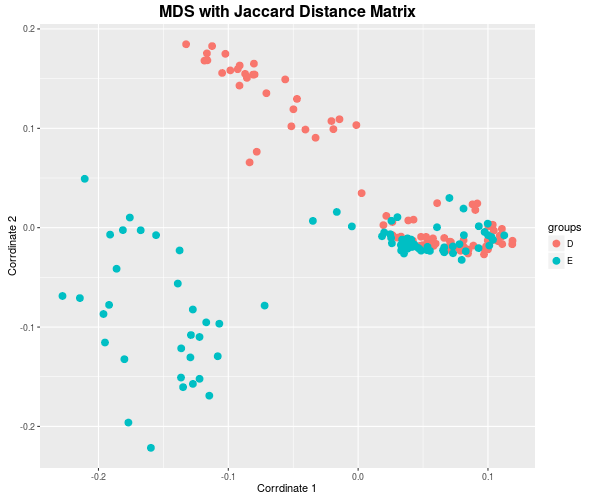

In [141]:
%%R -w 600 -h 500
cluster.cord <- plotCluster(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE)

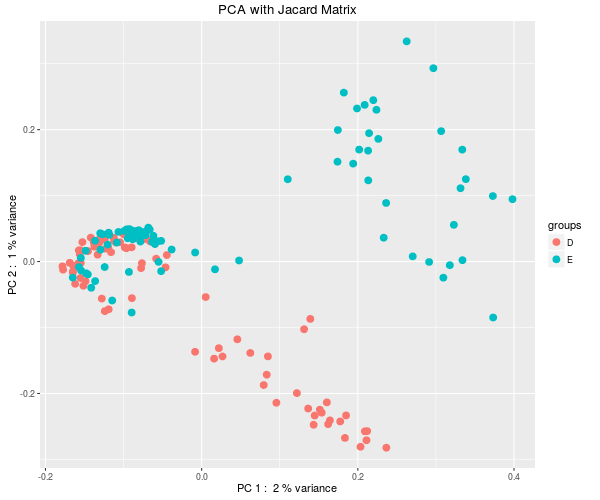

In [142]:
%%R -w 600 -h 500
cluster.cord <- plotPCAJaccard(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE)

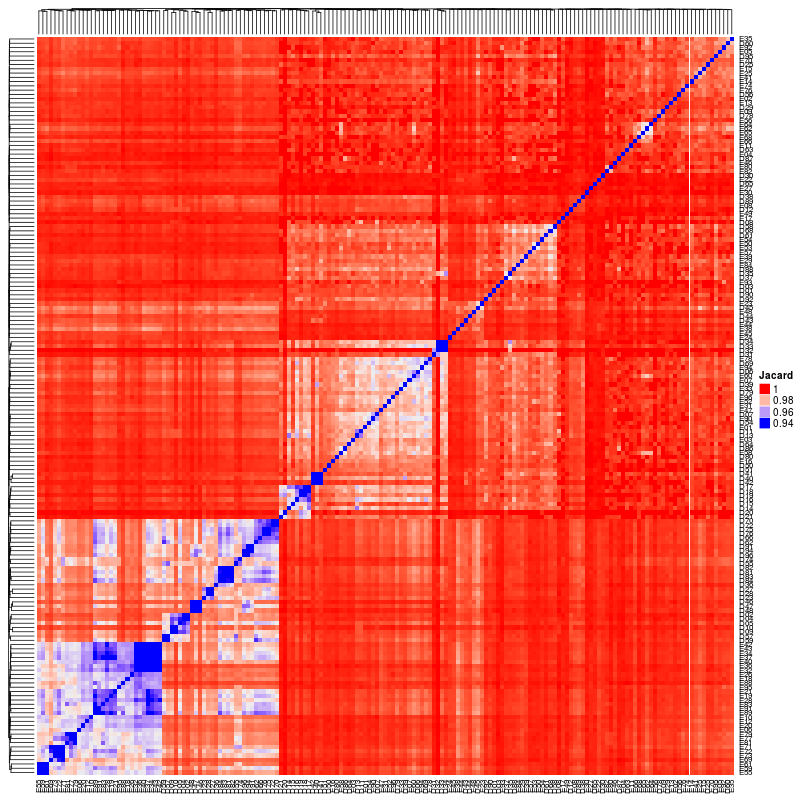

In [143]:
%%R -w 800 -h 800 
hc <- plotHeatmapJaccard(cdFinal, ret.val=TRUE)

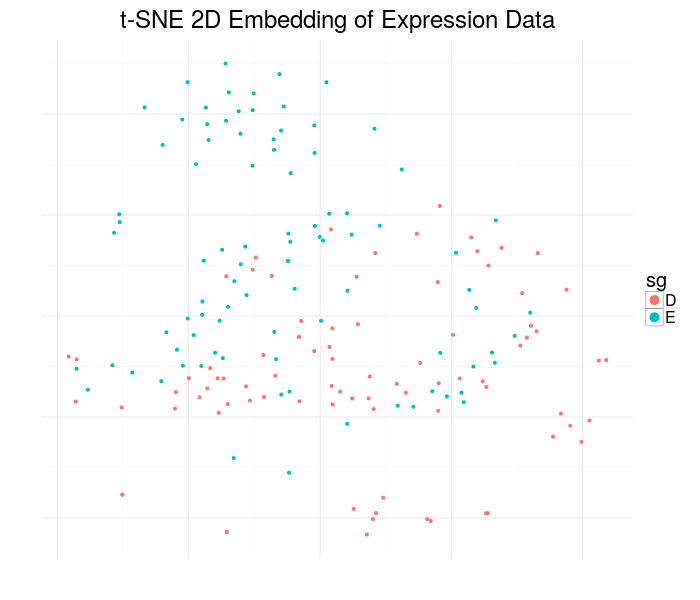

In [144]:
%%R -w 700 -h 600
tsne_out <- Rtsne(t(cdFinal[,4:dim(cdFinal)[2]]),check_duplicates = FALSE, pca = TRUE, 
              perplexity=30, theta=0.0)
p <- ggplot(as.data.frame(tsne_out$Y), aes(x=V1, y=V2, color=sg)) +
     geom_point(size=1.25) +
     guides(colour = guide_legend(override.aes = list(size=4))) +
     xlab("") + ylab("") +
     ggtitle("t-SNE 2D Embedding of Expression Data") +
     theme_light(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
print(p)

In [145]:
%%R -i mergedPeakFile,peakFolder,peakFilePattern,outputFolder
peakAccesibility(mergedPeakFile, peakFolder, peakFilePattern, outputFolder, topX=50000)

In [146]:
%%R -w 600 -h 600 -i peakFile
cdFinal <- read.csv(peakFile, header=TRUE)

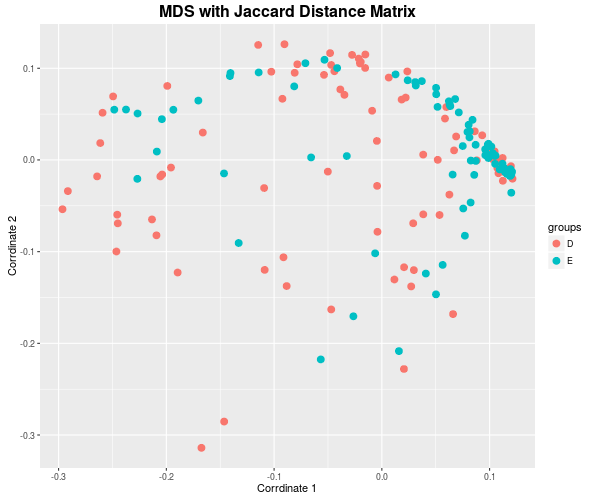

In [147]:
%%R -w 600 -h 500
cluster.cord <- plotCluster(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE)

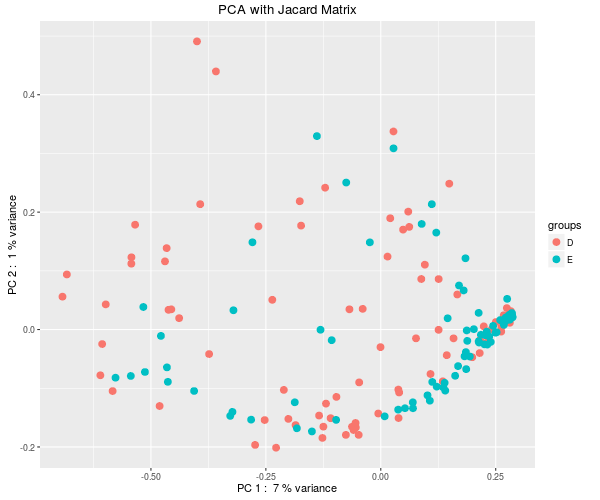

In [148]:
%%R -w 600 -h 500
cluster.cord <- plotPCAJaccard(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE)

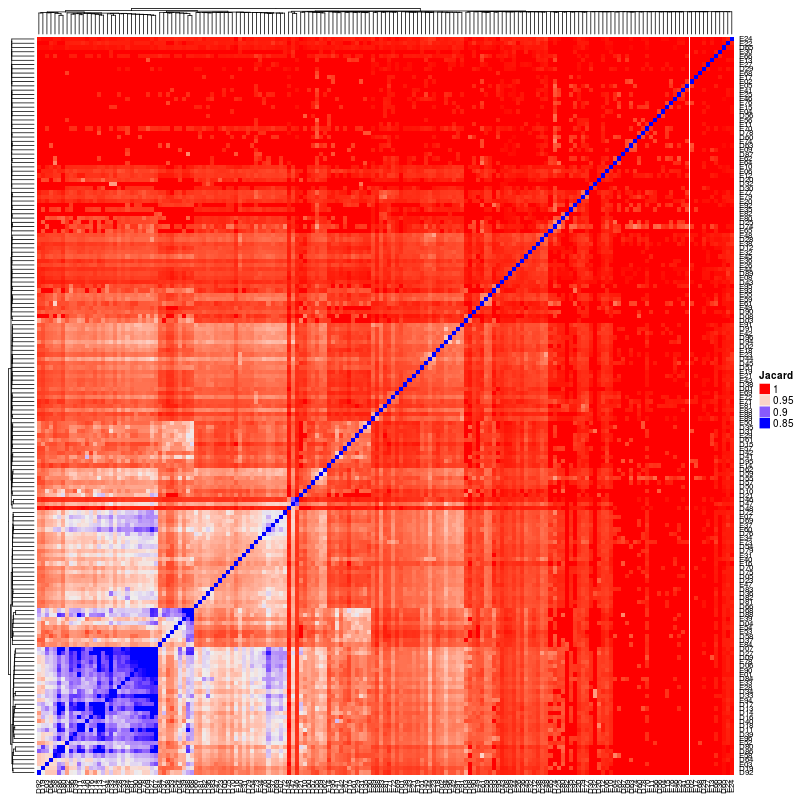

In [149]:
%%R -w 800 -h 800 
hc <- plotHeatmapJaccard(cdFinal, ret.val=TRUE)

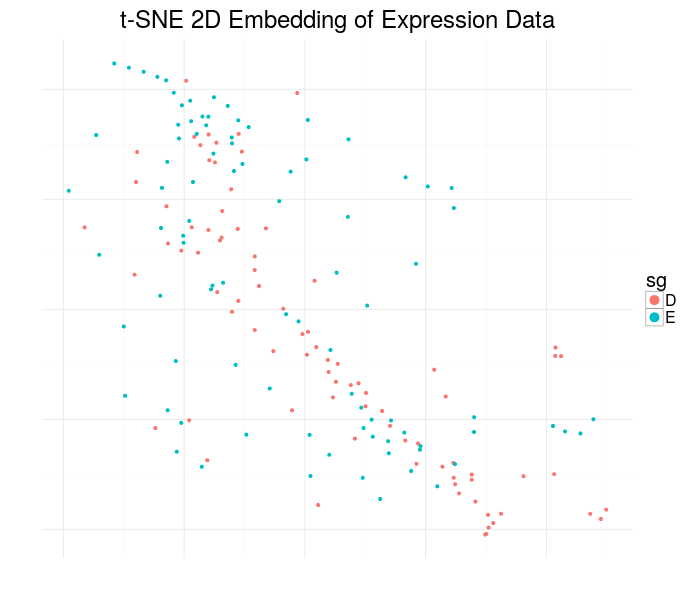

In [150]:
%%R -w 700 -h 600
tsne_out <- Rtsne(t(cdFinal[,4:dim(cdFinal)[2]]),check_duplicates = FALSE, pca = TRUE, 
              perplexity=30, theta=0.0)
p <- ggplot(as.data.frame(tsne_out$Y), aes(x=V1, y=V2, color=sg)) +
     geom_point(size=1.25) +
     guides(colour = guide_legend(override.aes = list(size=4))) +
     xlab("") + ylab("") +
     ggtitle("t-SNE 2D Embedding of Expression Data") +
     theme_light(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
print(p)

From the above figures it is clear that using Trimmomatic does not change the result

## Using BAM merge Files

In [155]:
BAMFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/'
BAMFilePattern = '_nodup_sorted.bam'

In [156]:
getAggregatedPeak(BAMFolder, BAMFilePattern)

In [174]:
# This cell holds the parameters for the tools

# Set this parameter to the folder where all the Peak Files are
peakFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredMacs2Files/'

# Set this parameter to the pattern that is common to all the peak file names that you wish to merge. 
# for eg, if you want to combine OE19_C01_peaks.narrowPeak and OE19_C02_peaks.narrowPeak then the
# pattern would be '_peaks.narrowPeak'
# Allowed patterns while calling with the pipeline provided here are
# _summits_shifted.bed and '_peaks.narrowPeak'
peakFilePattern = '_peaks.narrowPeak'

# This would be automatically set to 'mergedPeaks.bed' file in peakFolder folder
mergedPeakFile = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/mergedPeaks.bed'

# Set this folder to where the PeakHits.csv File would be saved
outputFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/'

# This will be automatically set to the 'PeakHits.csv' file in outputFolder folder
peakFile = outputFolder + 'PeakHits.csv'

In [175]:
%%R -i mergedPeakFile,peakFolder,peakFilePattern,outputFolder
print(peakFolder)

[1] "/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredMacs2Files/"


In [176]:
%%R -i mergedPeakFile,peakFolder,peakFilePattern,outputFolder
peakAccesibility(mergedPeakFile, peakFolder, peakFilePattern, outputFolder)

In [177]:
%%R -w 600 -h 600 -i peakFile
cdFinal <- read.csv(peakFile, header=TRUE)

In [178]:
%%R
#colnames(cdFinal)

sg <- factor(gsub("(D|E).*", "\\1", colnames(cdFinal[,4:dim(cdFinal)[2]])), levels = c("D", "E"))
# the group factor should be named accordingly
names(sg) <- colnames(cdFinal[,4:dim(cdFinal)[2]]) 
table(sg)

sg
 D  E 
84 89 


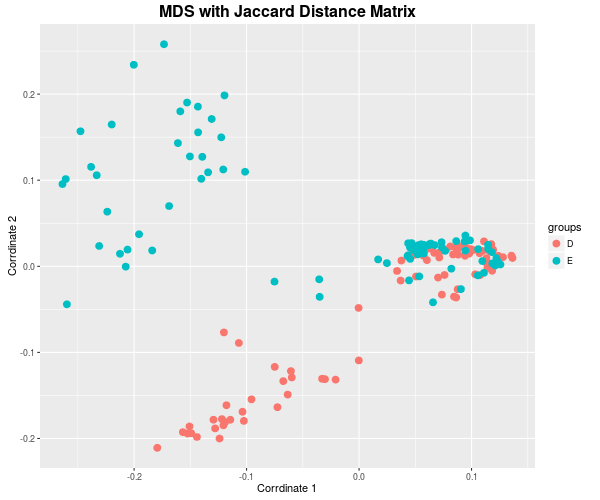

In [179]:
%%R -w 600 -h 500
cluster.cord <- plotCluster(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE)

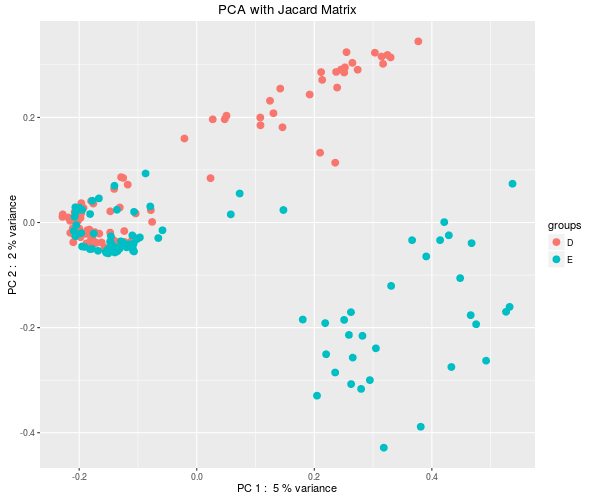

In [180]:
%%R -w 600 -h 500
cluster.cord <- plotPCAJaccard(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE)

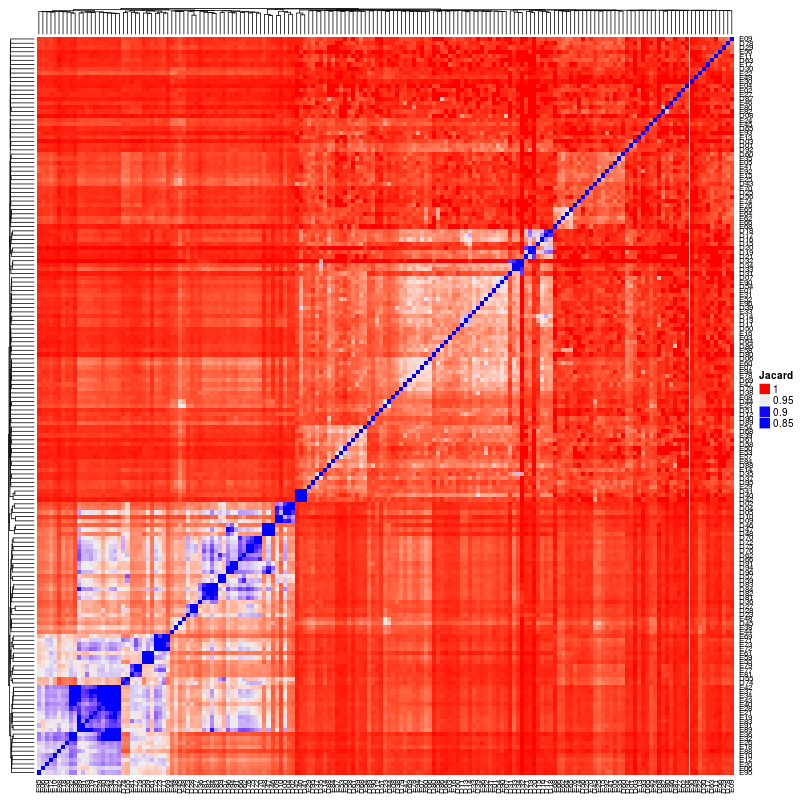

In [181]:
%%R -w 800 -h 800 
hc <- plotHeatmapJaccard(cdFinal, ret.val=TRUE)

### With top 50000 Peaks

In [182]:
%%R -i mergedPeakFile,peakFolder,peakFilePattern,outputFolder
peakAccesibility(mergedPeakFile, peakFolder, peakFilePattern, outputFolder, topX=50000)

In [183]:
%%R -w 600 -h 600 -i peakFile
cdFinal <- read.csv(peakFile, header=TRUE)

In [189]:
%%R
#colnames(cdFinal)

sg <- factor(gsub("(D|E).*", "\\1", colnames(cdFinal[,4:dim(cdFinal)[2]])), levels = c("D", "E"))
# the group factor should be named accordingly
names(sg) <- colnames(cdFinal[,4:dim(cdFinal)[2]]) 
table(sg)

sg
 D  E 
84 89 


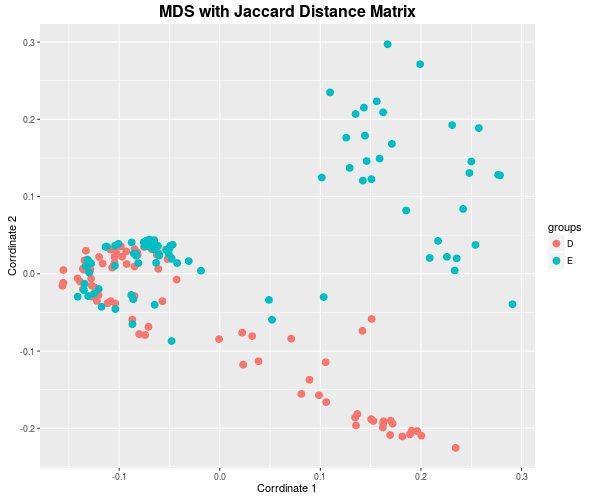

In [190]:
%%R -w 600 -h 500
cluster.cord <- plotCluster(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE)

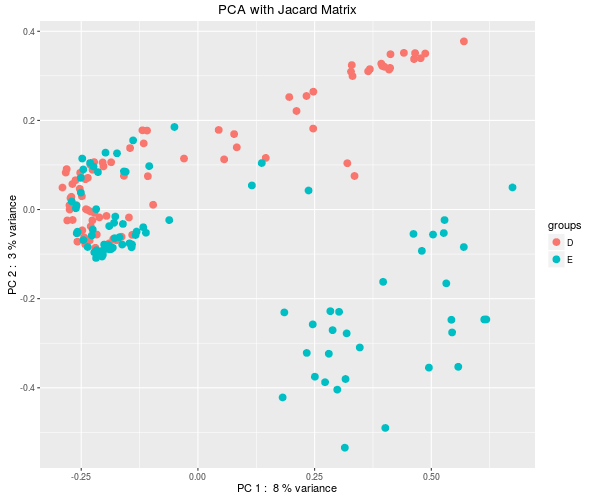

In [191]:
%%R -w 600 -h 500
cluster.cord <- plotPCAJaccard(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE)

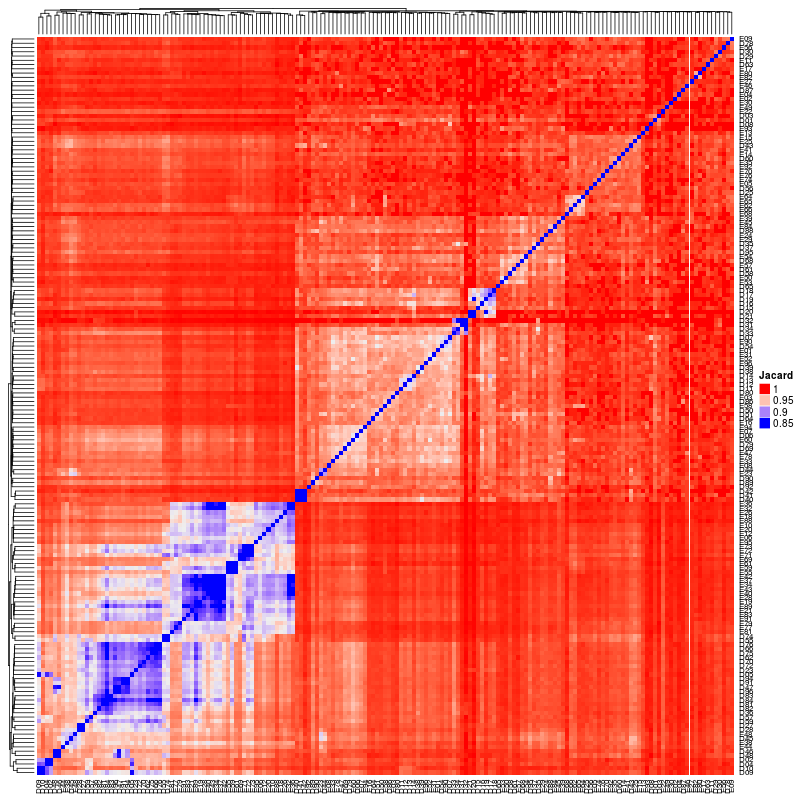

In [192]:
%%R -w 800 -h 800 
hc <- plotHeatmapJaccard(cdFinal, ret.val=TRUE)

### With Top 20000 Peaks

In [201]:
%%R -i mergedPeakFile,peakFolder,peakFilePattern,outputFolder
peakAccesibility(mergedPeakFile, peakFolder, peakFilePattern, outputFolder, topX=20000)

  seqnames    start      end width strand       name
1    chr17 27278209 27279992  1784      * 262.580115
2    chr17 27481628 27483222  1595      *  175.55467
3    chr17 39768687 39771008  2322      * 171.065385
4    chr11 82867502 82868273   772      *  159.44136
5     chr7 25901719 25902564   846      *  150.34676
6     chr6 43894347 43895410  1064      *  150.34676


In [194]:
%%R -w 600 -h 600 -i peakFile
cdFinal <- read.csv(peakFile, header=TRUE)

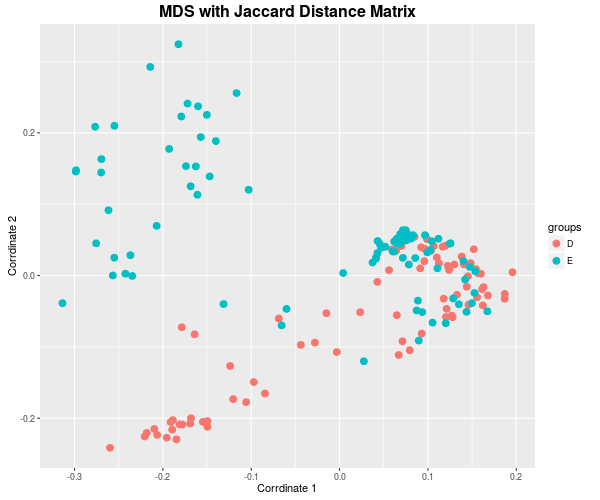

In [195]:
%%R -w 600 -h 500
cluster.cord <- plotCluster(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE)

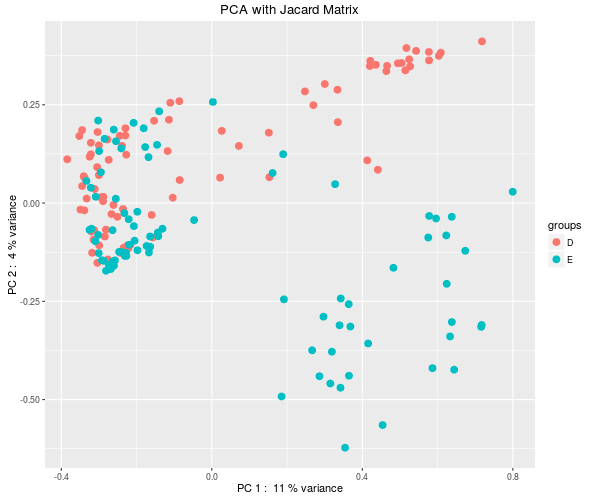

In [196]:
%%R -w 600 -h 500
cluster.cord <- plotPCAJaccard(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE)

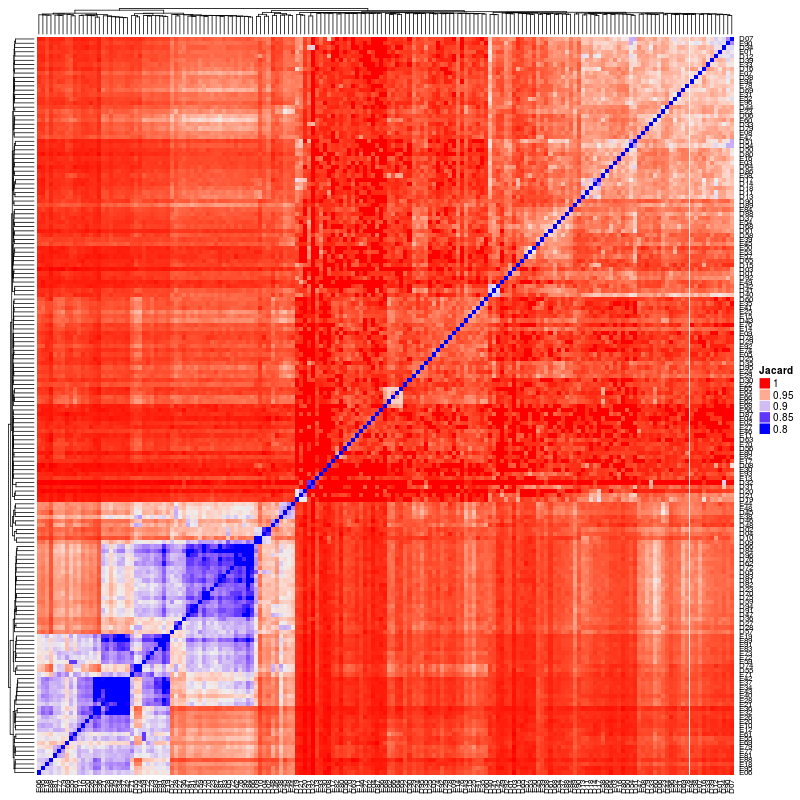

In [197]:
%%R -w 800 -h 800 
hc <- plotHeatmapJaccard(cdFinal, ret.val=TRUE)

### Trying with the_narrow_peak file without merging

In [260]:
! awk '{print $1,$2,$3,$9}' /home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/AllFilteredBAM_peaks.narrowPeak > /home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/tmpCollapsedBam.txt
! sort -nrk4   /home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/tmpCollapsedBam.txt >  /home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/collapsed_BAM_peaks.narrowPeak.bed
! rm /home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/tmpCollapsedBam.txt

In [261]:
# This cell holds the parameters for the tools

# Set this parameter to the folder where all the Peak Files are
peakFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredMacs2Files/'

# Set this parameter to the pattern that is common to all the peak file names that you wish to merge. 
# for eg, if you want to combine OE19_C01_peaks.narrowPeak and OE19_C02_peaks.narrowPeak then the
# pattern would be '_peaks.narrowPeak'
# Allowed patterns while calling with the pipeline provided here are
# _summits_shifted.bed and '_peaks.narrowPeak'
peakFilePattern = '_peaks.narrowPeak'

# Set this file to the merged Peak File
# This file has to have four columns and has to be sorted based on top peaks
mergedPeakFile = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/collapsed_BAM_peaks.narrowPeak.bed'

# Set this folder to where the outputPeakFileName File would be saved
outputFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/'

# Set the outputPeakFileName name here
outputPeakFileName = 'peakHits_NotMerging.csv'

# This will be automatically set to the 'PeakHits.csv' file in outputFolder folder
peakFile = outputFolder + outputPeakFileName

In [262]:
%%R -i mergedPeakFile,peakFolder,peakFilePattern,outputFolder,outputPeakFileName
peakAccesibility(mergedPeakFile, peakFolder, peakFilePattern, outputFolder, outputPeakFileName)

   seqnames     start       end width strand       name
1     chr17  39941327  39944011  2685      * 1458.78394
2     chr17  39808331  39813633  5303      * 1130.86646
3     chr17  39808331  39813633  5303      *  909.59412
4     chr17  39956459  39960338  3880      *  799.92145
5     chr17  37909233  37911996  2764      *  689.36157
6     chr17  39926281  39930567  4287      *  655.76367
7     chr17  37830279  37836075  5797      *  652.97321
8     chr17  39948450  39950823  2374      *  619.64172
9     chr17  37860643  37864814  4172      *  594.80255
10    chr17  37830279  37836075  5797      *  592.04999
11    chr17  37891739  37898087  6349      *  575.57202
12    chr17  37854776  37856859  2084      *  537.38513
13    chr17  37830279  37836075  5797      *  534.67242
14    chr17  37885128  37888485  3358      *  496.86966
15    chr17  37891739  37898087  6349      *  454.10269
16    chr17  37842871  37845681  2811      *  448.79382
17    chr17  37891739  37898087  6349      *  43

In [263]:
%%R -w 600 -h 600 -i peakFile
cdFinal <- read.csv(peakFile, header=TRUE)

In [264]:
%%R
#colnames(cdFinal)

sg <- factor(gsub("(D|E).*", "\\1", colnames(cdFinal[,4:dim(cdFinal)[2]])), levels = c("D", "E"))
# the group factor should be named accordingly
names(sg) <- colnames(cdFinal[,4:dim(cdFinal)[2]]) 
table(sg)

sg
 D  E 
84 89 


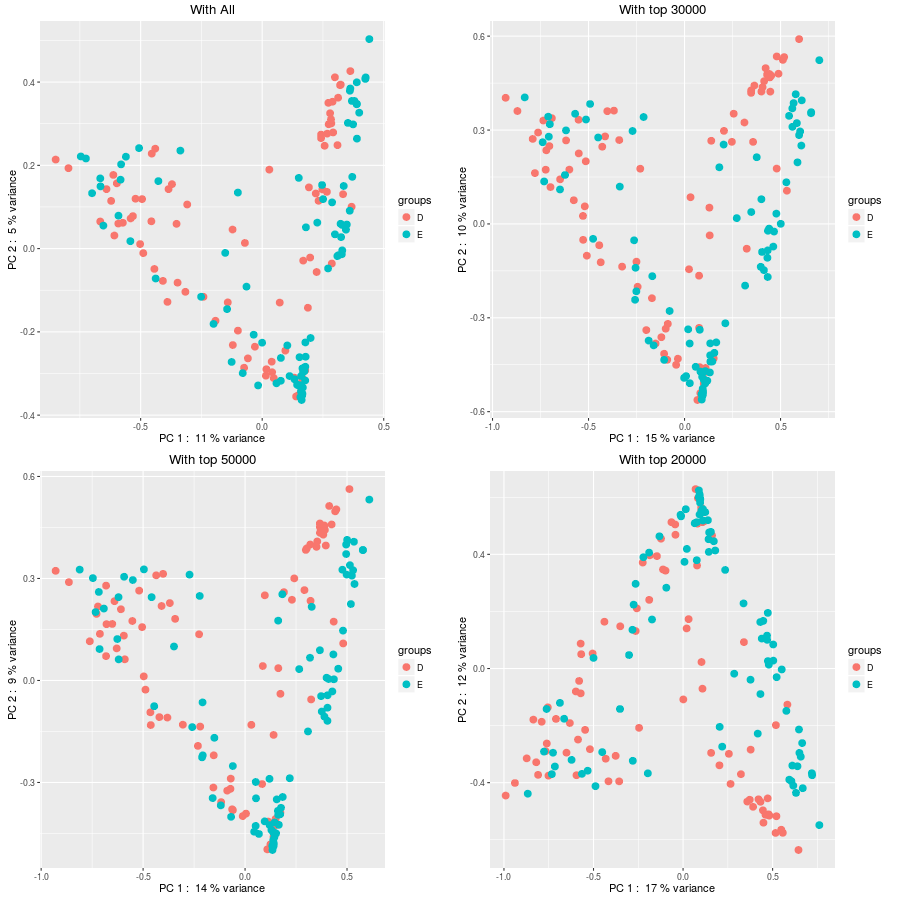

In [265]:
%%R -w 900 -h 900
p1 <- plotPCAJaccard(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With All")
topX=50000
p2 <- plotPCAJaccard(cdFinal[1:topX,], k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With top 50000")
topX=30000
p3 <- plotPCAJaccard(cdFinal[1:topX,], k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With top 30000")

topX=20000
p4 <- plotPCAJaccard(cdFinal[1:topX,], k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With top 20000")
multiplot(p1,p2,p3,p4,cols=2)

## With merged peaks again

In [251]:
# This cell holds the parameters for the tools

# Set this parameter to the folder where all the Peak Files are. This has to be the folder
# where each of the individual cells peak files reside
peakFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredMacs2Files/'

# Set this parameter to the folder where the peaks for the merge files are. This can be the same folder
# of all the individual cells peak folder or can be a single peak file that is generated from merging BAM files
peakFolderToMerge = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/'

# Set this parameter to the pattern that is common to all the peak file names that you wish to merge. 
# for eg, if you want to combine OE19_C01_peaks.narrowPeak and OE19_C02_peaks.narrowPeak then the
# pattern would be '_peaks.narrowPeak'
# Allowed patterns while calling with the pipeline provided here are
# _summits_shifted.bed and '_peaks.narrowPeak'
peakFilePattern = '_peaks.narrowPeak'

# This would be automatically set to 'mergedPeaks.bed' file in peakFolder folder
mergedPeakFile = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/mergedPeaks.bed'

# Set this folder to where the PeakHits.csv File would be saved
outputFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/'

# Set the outputPeakFileName name here
outputPeakFileName = 'PeakHits.csv'

# This will be automatically set to the 'PeakHits.csv' file in outputFolder folder
peakFile = outputFolder + outputPeakFileName


In [246]:
mergePeaks(peakFolderToMerge, peakFilePattern)

In [256]:
%%R -i mergedPeakFile,peakFolder,peakFilePattern,outputFolder,outputPeakFileName
peakAccesibility(mergedPeakFile, peakFolder, peakFilePattern, outputFolder, outputPeakFileName)

   seqnames     start       end width strand       name
1     chr17  27278209  27279992  1784      * 262.580115
2     chr17  27481628  27483222  1595      *  175.55467
3     chr17  39768687  39771008  2322      * 171.065385
4     chr11  82867502  82868273   772      *  159.44136
5      chr7  25901719  25902564   846      *  150.34676
6      chr6  43894347  43895410  1064      *  150.34676
7      chr2 106413183 106413341   159      *  145.82919
8     chr20  52739853  52740696   844      *  145.82919
9     chr14  96000903  96001490   588      *   134.6362
10     chr9  82186258  82186982   725      *  125.78249
11    chr17  39941327  39944011  2685      *  125.78249
12    chr10  76585612  76586836  1225      *  125.78249
13    chr15  89630956  89631804   849      *  123.58316
14    chr17  27386362  27386951   590      *   119.2078
15     chr1 143913085 143913846   762      *   119.2078
16    chr20  26188738  26189434   697      * 117.966615
17    chr13  34730979  34731830   852      *  11

In [257]:
%%R -w 600 -h 600 -i peakFile
cdFinal <- read.csv(peakFile, header=TRUE)

In [258]:
%%R
#colnames(cdFinal)

sg <- factor(gsub("(D|E).*", "\\1", colnames(cdFinal[,4:dim(cdFinal)[2]])), levels = c("D", "E"))
# the group factor should be named accordingly
names(sg) <- colnames(cdFinal[,4:dim(cdFinal)[2]]) 
table(sg)

sg
 D  E 
84 89 


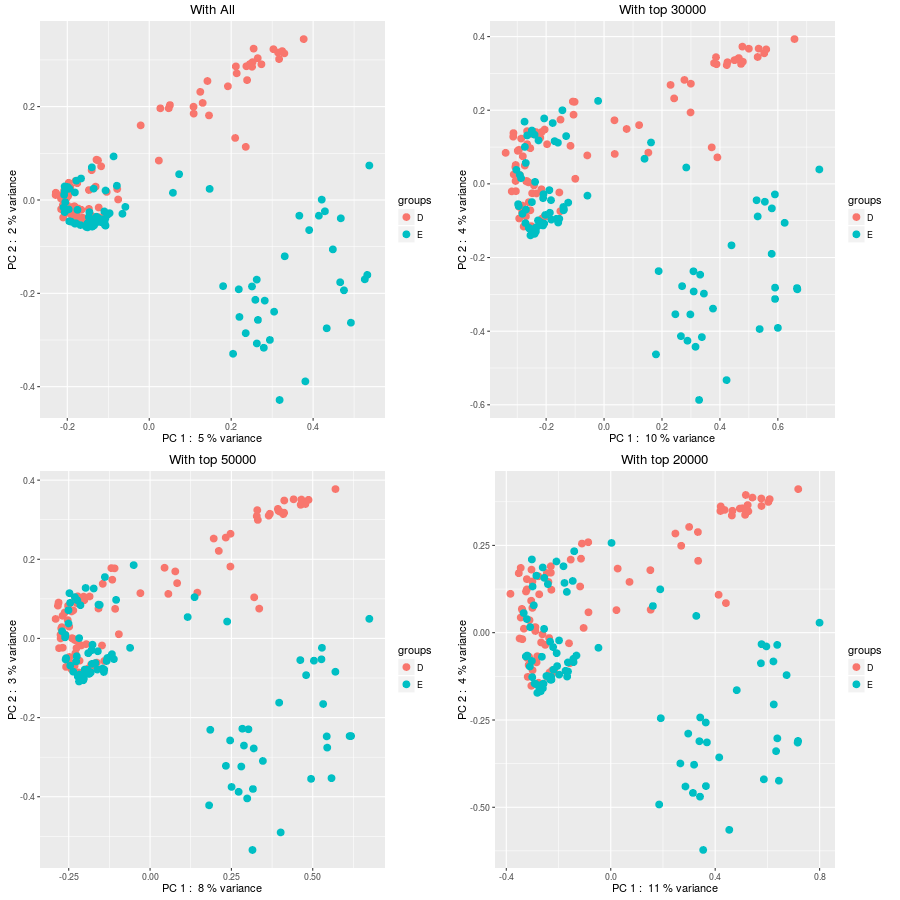

In [259]:
%%R -w 900 -h 900
p1 <- plotPCAJaccard(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With All")
topX=50000
p2 <- plotPCAJaccard(cdFinal[1:topX,], k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With top 50000")
topX=30000
p3 <- plotPCAJaccard(cdFinal[1:topX,], k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With top 30000")

topX=20000
p4 <- plotPCAJaccard(cdFinal[1:topX,], k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With top 20000")
multiplot(p1,p2,p3,p4,cols=2)

## Differential Analysis

In [187]:
%%R
cdDe <- getDiffBind(cdFinal, groups=sg)

In [198]:
%%R
cdDeSorted <- cdDe[order(cdDe$p_adjust, decreasing=FALSE),]
cdDeSorted <- cdDeSorted[cdDeSorted$p_adjust <0.1,]
#cdDeSorted